# Pure Particle FCC Tensile Notes

Required source files:
* `modeling.in` : for creating a cylinder model.
* `deform.in` : runs a deformation as tensile test while recording desire variables.


## Create a Cylinder model

In [1]:
import subprocess
return_code = subprocess.call(['lmp_serial', '-in', 'create_cylinder.lmps'])

LAMMPS (2 Aug 2023)
Lattice spacing in x,y,z = 0.0002 0.0002 0.0002
Created orthogonal box = (-0.0006 -0.0006 -0.001) to (0.0006 0.0006 0.001)
  1 by 1 by 1 MPI processor grid
Created 1090 atoms
  using lattice units in orthogonal box = (-0.0006 -0.0006 -0.001) to (0.0006 0.0006 0.001)
  create_atoms CPU = 0.000 seconds
System init for write_data ...
Total wall time: 0:00:00


## Read Cylinder model and simulate tensile strength test

In [32]:
import os
if os.path.exists('./data/ss.txt'):
    os.remove('./data/ss.txt')
    
return_code = subprocess.call(['mpirun', '-np', '4', 'lmp_mpi', '-pk', 'omp', '4', '-in', 'deform.lmps'])

LAMMPS (2 Aug 2023)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
set 4 OpenMP thread(s) per MPI task
using multi-threaded neighbor list subroutines
Lattice spacing in x,y,z = 0.0002 0.0002 0.0002
Reading data file ...
  orthogonal box = (-0.0006 -0.0006 -0.001) to (0.0006 0.0006 0.001)
  1 by 2 by 2 MPI processor grid
  reading atoms ...
  1090 atoms
  reading velocities ...
  1090 velocities
  read_data CPU = 0.003 seconds
ERROR: Illegal compute reduce argument: c_stressatom[*] (src/compute_reduce.cpp:179)
Last command: compute         sta all reduce sum c_stressatom[*]       				# Sum of stresses over all atoms


## Post-Process data

In [28]:
import pandas as pd
from pandas import DataFrame as df

# load data
ss_directory = "./data/ss.txt"
with open(ss_directory, 'r') as file:
    data = pd.read_csv(file, sep=' ')[['strain', 'stress33']]

slopes = [0,]
data['stress33'][1]
for i in range(1, len(data.index)):
    slopes.append((data['stress33'][i] - data['stress33'][i-1])/(data['strain'][i] - data['strain'][i-1]))
    

data['slope'] = slopes
data

,strain,stress33,slope
0,0.0000,-4.545352e-04,0.000000e+00
1,0.0001,4.068166e+06,4.068166e+10
2,0.0002,7.890252e+06,3.822086e+10
3,0.0003,1.130110e+07,3.410845e+10
4,0.0004,1.433919e+07,3.038096e+10
...,...,...,...
1496,0.1496,3.012125e+09,9.573371e+09
1497,0.1497,3.013123e+09,9.980230e+09
1498,0.1498,3.014161e+09,1.038051e+10
1499,0.1499,3.015235e+09,1.073668e+10


Text(0, 0.5, '$\\sigma$ (Pa)')

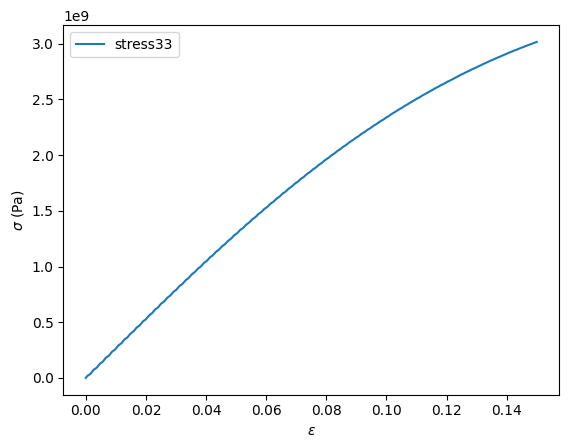

In [30]:
# plot
plt = data.plot(x='strain', y=['stress33'])
plt.set_xlabel('$\epsilon$')
plt.set_ylabel('$\sigma$ (Pa)')

## Getting linear part slope for Young's modulus